In [85]:
import os 
#set working directory
os.chdir("../")

In [86]:
# show current working directory
print(os.getcwd())

/Users/bguenes/Documents/Uni/Master


In [87]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
from scipy.stats import norm
from scipy.stats import multivariate_normal
from tqdm import tqdm

from Chempy.parameter import ModelParameters

import sbi.utils as utils

import torch
from torch.distributions.normal import Normal
from torch.distributions.uniform import Uniform

import time as t
import pickle

In [88]:
# ----- Load the data -----
a = ModelParameters()
labels = [a.to_optimize[i] for i in range(len(a.to_optimize))] + ['time']
priors = torch.tensor([[a.priors[opt][0], a.priors[opt][1]] for opt in a.to_optimize])

elements = a.elements_to_trace

In [89]:
# ----- Load posterior -----
with open('master_thesis/data/posterior_sbi.pickle', 'rb') as f:
    posterior = pickle.load(f)

FileNotFoundError: [Errno 2] No such file or directory: 'master_thesis/data/posterior_sbi.pickle'

In [ ]:
# ----- Load the NN -----
class Model_Torch(torch.nn.Module):
    def __init__(self):
        super(Model_Torch, self).__init__()
        self.l1 = torch.nn.Linear(len(labels), 100)
        self.l2 = torch.nn.Linear(100, 40)
        self.l3 = torch.nn.Linear(40, len(elements))

    def forward(self, x):
        x = torch.tanh(self.l1(x))
        x = torch.tanh(self.l2(x))
        x = self.l3(x)
        return x
    
model = Model_Torch()
model.load_state_dict(torch.load('master_thesis/data/pytorch_state_dict.pt'))
model.eval();

# Setup priors
The inputs to the model are drawn from a fixed set of global galaxy parameters (slope of the IMF & Rate of Type Ia Supernove) and a set of local star parameters.

In [ ]:
local_GP = utils.MultipleIndependent(
    [Normal(p[0]*torch.ones(1), p[1]*torch.ones(1)) for p in priors[2:]] +
    [Uniform(torch.tensor([2.0]), torch.tensor([12.8]))],
    validate_args=False)

global_GP = utils.MultipleIndependent(
    [Normal(p[0]*torch.ones(1), p[1]*torch.ones(1)) for p in priors[:2]],
    validate_args=False)

# Simulate data
With the set global priors and for each $N_{\rm stars}$ a set of local priors, we can simulate the data with the Neural Network.

In [ ]:
N_stars = 1000

stars = local_GP.sample((N_stars,))
global_params = torch.tensor([[-2.3, -2.89]])

stars = torch.cat((global_params.repeat(N_stars, 1), stars), dim=1)

In [ ]:
# ----- Simulate abundances -----
start = t.time()
abundances = model(stars)   
end = t.time()
print(f'Time to create data for {N_stars} stars: {end-start:.3f} s')

Time to create data for 1000 stars: 0.028 s


Run the sbi inference with the simulated data and save the output for all simulations.

In [ ]:
alpha_IMF = []
log10_N_Ia = []
simulations = 1000

start = t.time()
for i in tqdm(range(len(abundances))):
    alpha, N_Ia = posterior.sample((simulations,), x=abundances[i], show_progress_bars=False)[:,0:2].T
    alpha_IMF.append(alpha)
    log10_N_Ia.append(N_Ia)
end = t.time()
print(f'Time to run {simulations} simulations for {N_stars} stars: {end-start:.3f} s')

alpha_IMF = np.array(alpha_IMF).ravel()
log10_N_Ia = np.array(log10_N_Ia).ravel()

100%|██████████| 1000/1000 [04:34<00:00,  3.64it/s]

Time to run 1000 simulations for 1000 stars: 274.457 s


In [ ]:
# save the data
np.save('master_thesis/data/alpha_IMF.npy', alpha_IMF)
np.save('master_thesis/data/log10_N_Ia.npy', log10_N_Ia)

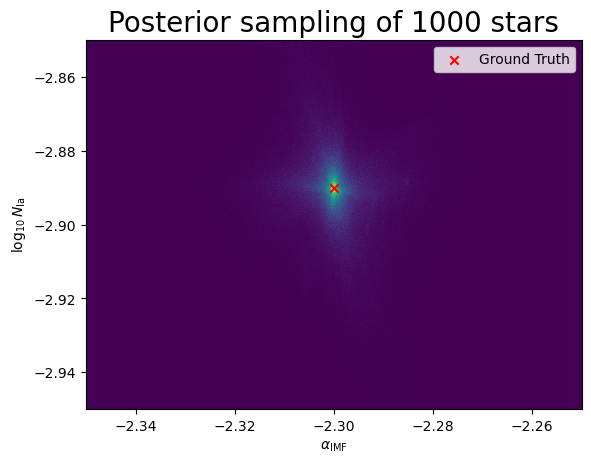

In [238]:
plt.hist2d(alpha_IMF, log10_N_Ia, bins=500, range=[[-2.35,-2.25],[-2.95,-2.85]])
plt.xlabel(r'$\alpha_{\rm IMF}$')
plt.ylabel(r'$\log_{10} N_{\rm Ia}$')
plt.scatter(global_params[0][0], global_params[0][1], color='r', marker='x', label="Ground Truth")
plt.title(f'Posterior sampling of {N_stars} stars', fontsize=20)
plt.legend()
plt.show();

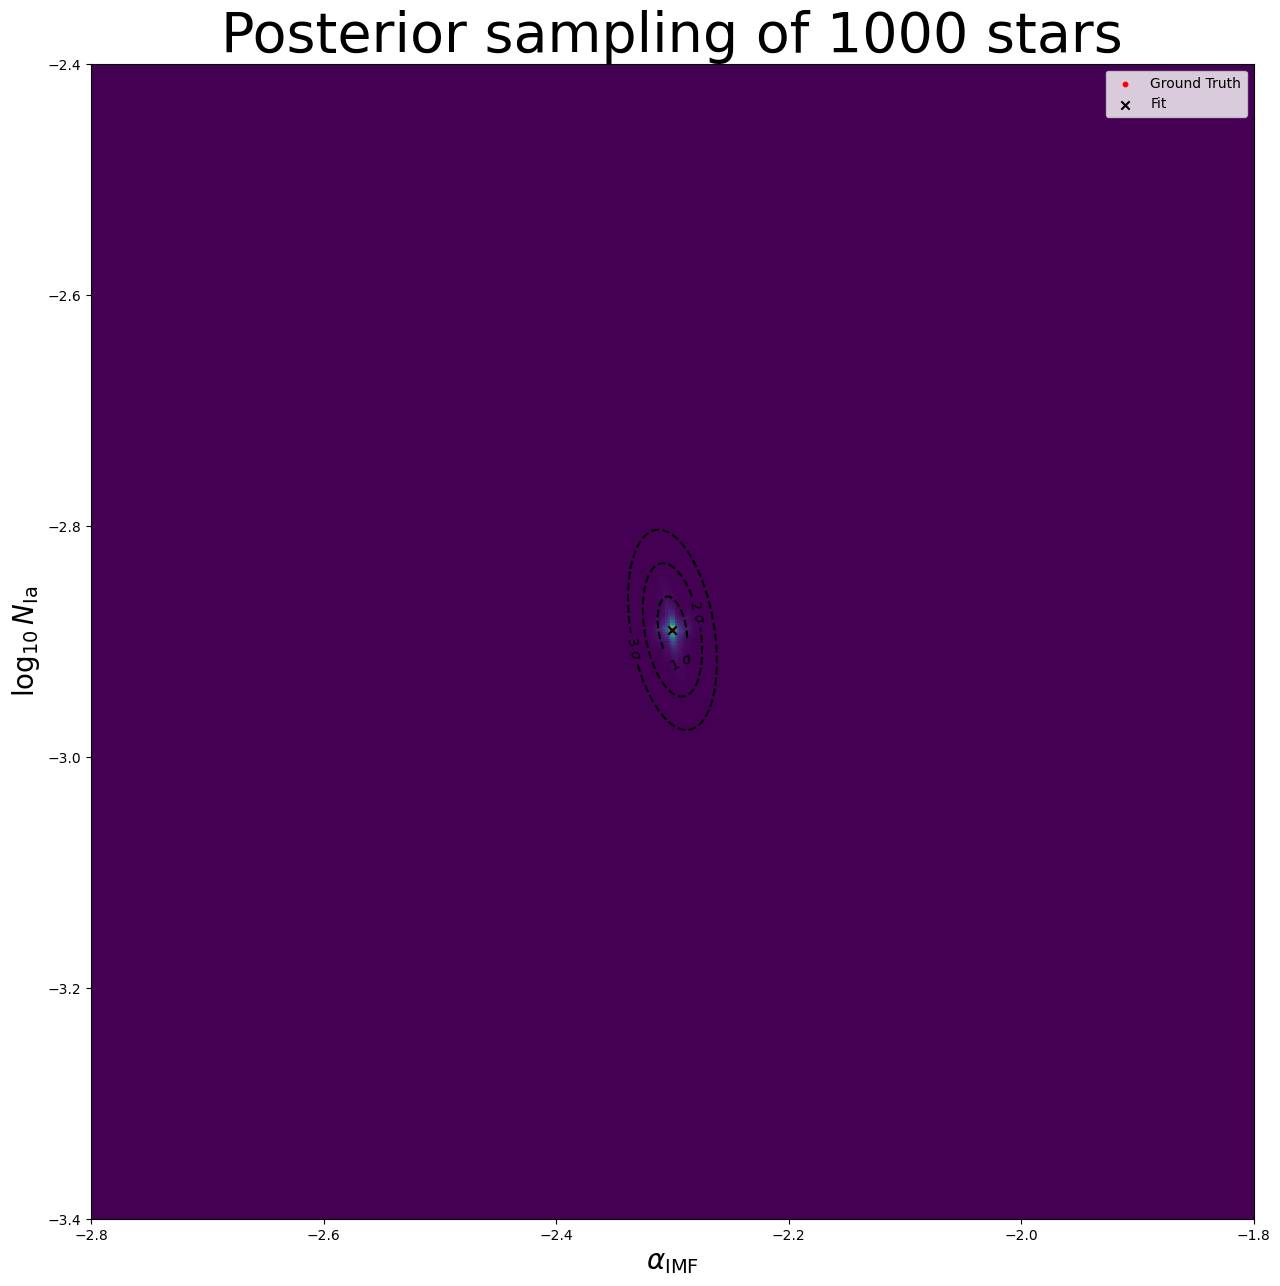

In [403]:
plot_2d_hist(alpha_IMF, log10_N_Ia, global_params[0])

In [ ]:
def plot_2d_hist(x1, x2, x_true, name):
    fig, ax = plt.subplots(1,2, figsize=(12,6))
    plot_width = 0.3
    
    x1_mean = np.mean(x1)
    x1_std = np.std(x1)
    x1_min = x_true[0] - plot_width*x_true[0]
    x1_max = x_true[0] + plot_width*x_true[0]
    
    lin1 = np.linspace(x1_min, x1_max, 1000)
    p1 = norm.pdf(lin1, x1_mean, x1_std)
    
    ax[0].hist(x1, bins=500, density=True, alpha=0.6, color='g')
    ax[0].plot(lin1, p1, 'k', linewidth=2)
    ax[0].axvline(x=x_true[0], color='r', linestyle='dashed', linewidth=2)
    ax[0].set_title(fr"{name[0]}: {x_true[0]:.3f}"
                    "\n"
                    fr"$\mu$: {x1_mean:.3f} $\sigma$: {x1_std:.3f}")
    ax[0].set_xlim(x1_min, x1_max)
    
    x2_mean = np.mean(x2)
    x2_std = np.std(x2)
    x2_min = x_true[1] - plot_width*x_true[1]
    x2_max = x_true[1] + plot_width*x_true[1]
    
    lin2 = np.linspace(x2_min, x2_max, 1000)
    p2 = norm.pdf(lin2, x2_mean, x2_std)
        
    ax[1].hist(x2, bins=500, density=True, alpha=0.6, color='g')
    ax[1].plot(lin2, p2, 'k', linewidth=2)
    ax[1].axvline(x=x_true[1], color='r', linestyle='dashed', linewidth=2)
    ax[1].set_title(fr"{name[1]}: {x_true[1]:.3f}"
                    "\n"
                    fr"$\mu$: {x2_mean:.3f} $\sigma$: {x2_std:.3f}")
    ax[1].set_xlim(x2_min, x2_max)
    
    fig.suptitle(f'{int(len(x1)/simulations)} Stars', fontsize=30)
    plt.tight_layout()
    plt.show()

1000 simulations for each star


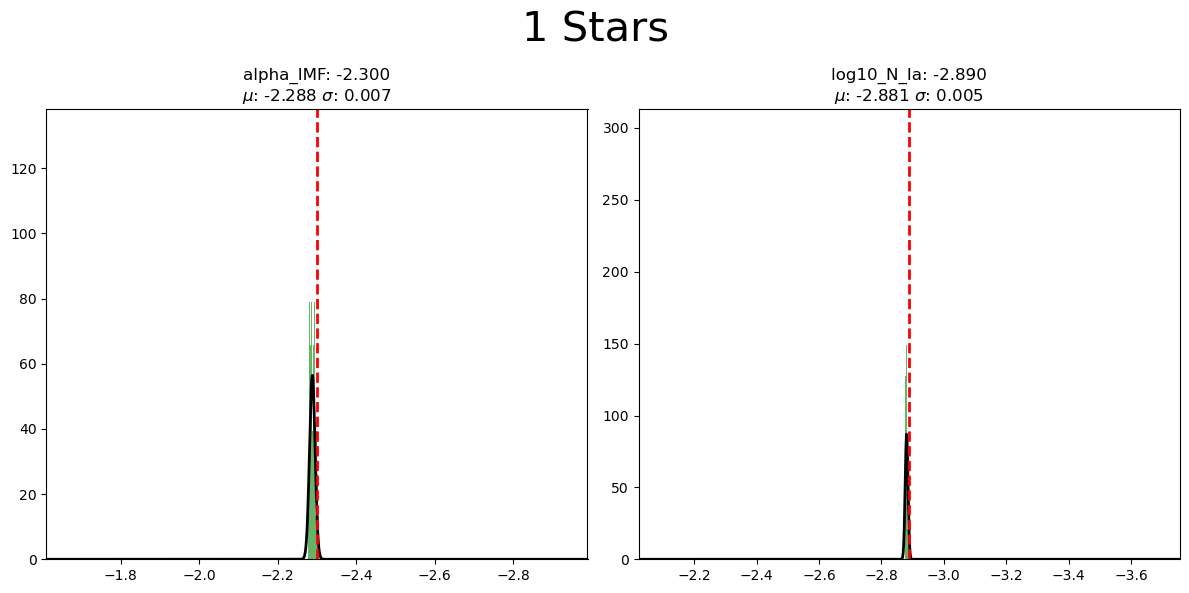

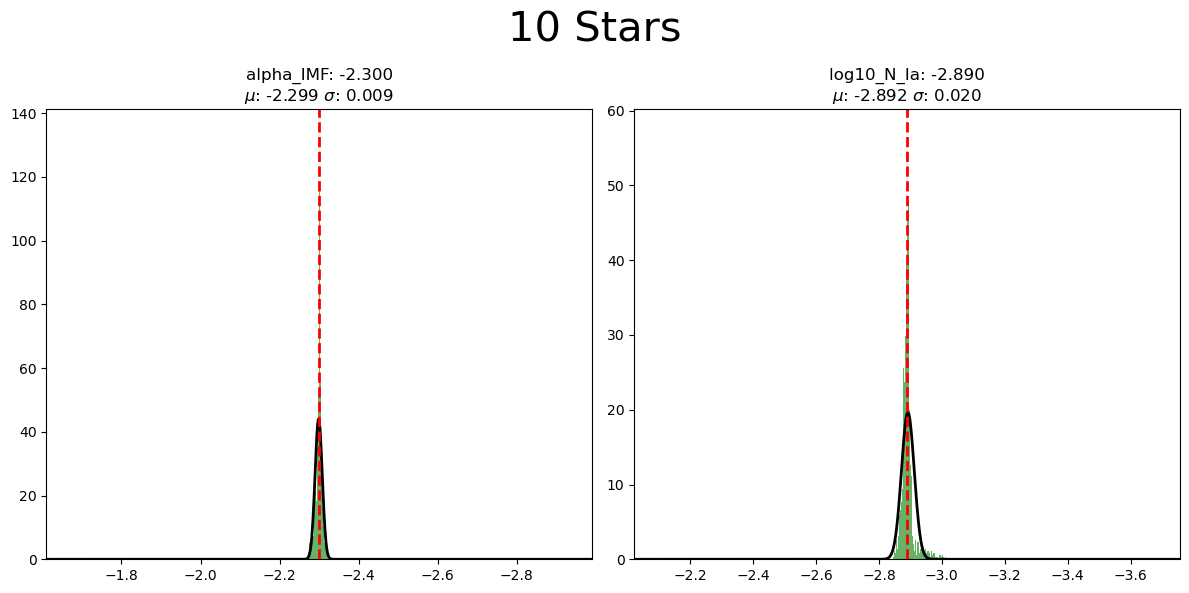

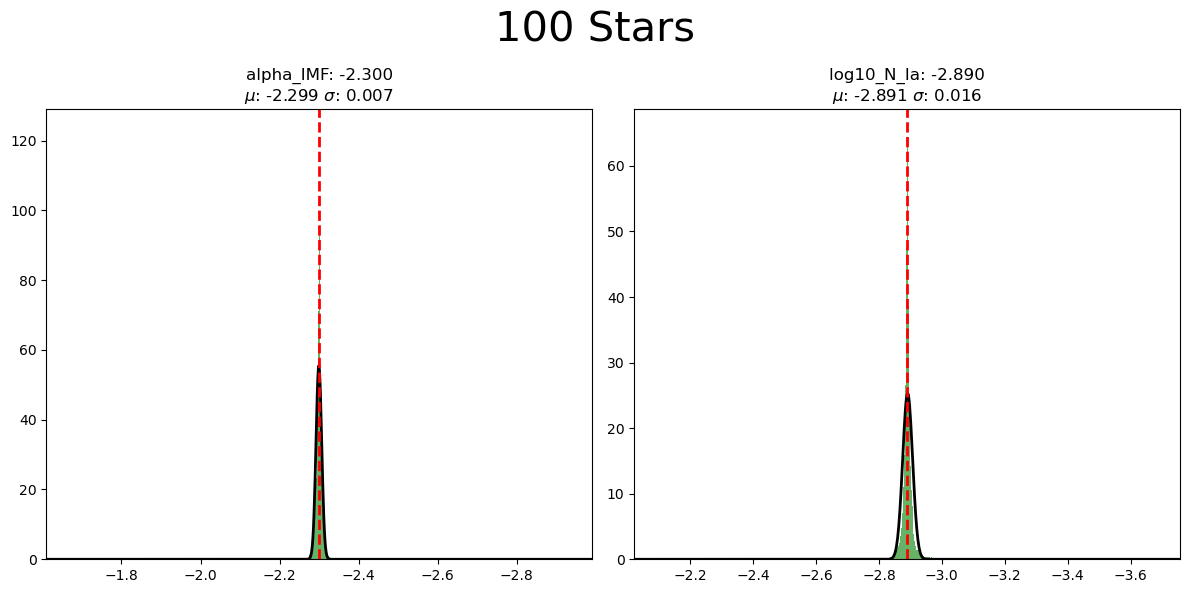

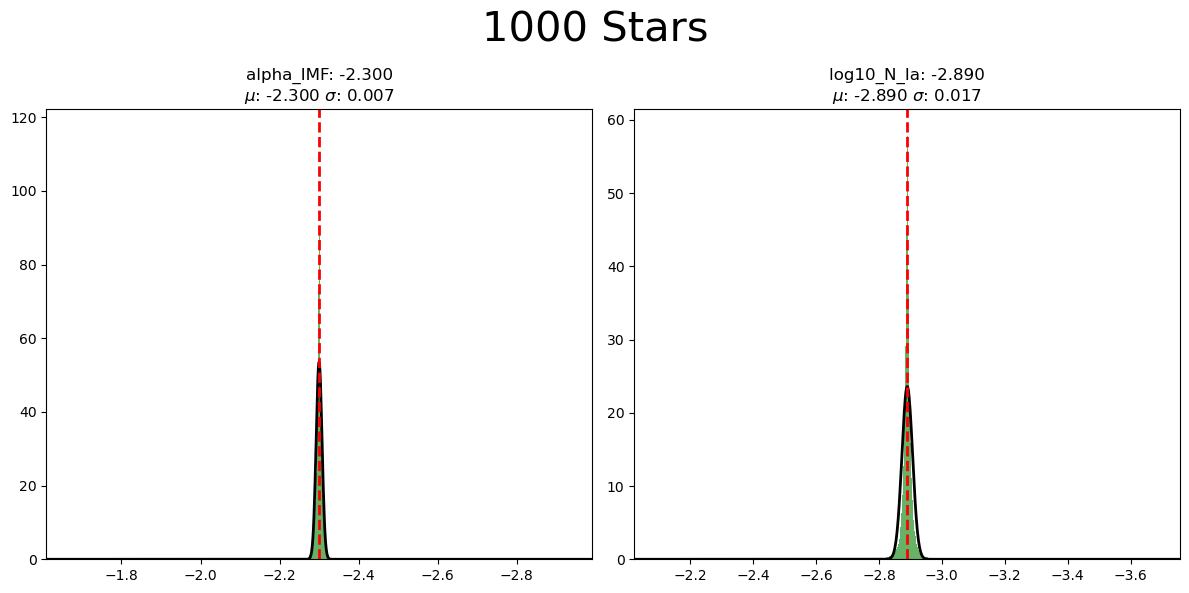

In [ ]:
sims = np.array([1, 10, 100, 1000]) * simulations
print(f"{simulations} simulations for each star")
for i in sims:
    plot_2d_hist(alpha_IMF[0:i], log10_N_Ia[0:i], global_params[0], ['alpha_IMF', 'log10_N_Ia'])

# Inference wit noise

In [ ]:
# ----- Load posterior -----
with open('master_thesis/data/posterior_sbi_w5p-error.pickle', 'rb') as f:
    posterior_noise = pickle.load(f)

In [ ]:
from scipy.stats import norm

def add_noise(true_abundances):
    # Define observational erorrs
    pc_ab = 5 # percentage error in abundance

    # Jitter true abundances and birth-times by these errors to create mock observational values.
    obs_ab_errors = np.ones_like(true_abundances)*float(pc_ab)/100.
    obs_abundances = norm.rvs(loc=true_abundances,scale=obs_ab_errors)

    return obs_abundances

In [ ]:
alpha_IMF_obs = []
log10_N_Ia_obs = []
simulations = 1000

start = t.time()
for i in tqdm(range(len(abundances))):
    x = add_noise(abundances[i].detach().numpy())
    alpha, N_Ia = posterior_noise.sample((simulations,), x=x, show_progress_bars=False)[:,0:2].T
    alpha_IMF_obs.append(alpha)
    log10_N_Ia_obs.append(N_Ia)
end = t.time()
print(f'Time to run {simulations} simulations for {N_stars} stars: {end-start:.3f} s')

alpha_IMF_obs = np.array(alpha_IMF_obs).ravel()
log10_N_Ia_obs = np.array(log10_N_Ia_obs).ravel()

100%|██████████| 1000/1000 [05:28<00:00,  3.04it/s]

Time to run 1000 simulations for 1000 stars: 328.648 s


In [ ]:
# save the data
np.save('master_thesis/data/alpha_IMF_obs.npy', alpha_IMF_obs)
np.save('master_thesis/data/log10_N_Ia_obs.npy', log10_N_Ia_obs)

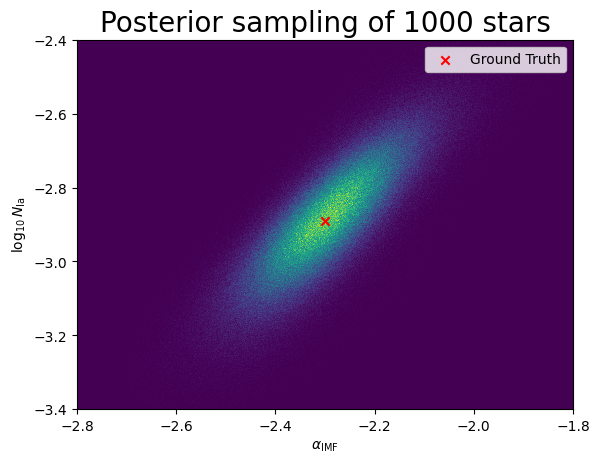

In [235]:
plt.hist2d(alpha_IMF_obs, log10_N_Ia_obs, bins=500, range=[[-2.8,-1.8],[-3.4,-2.4]])
plt.xlabel(r'$\alpha_{\rm IMF}$')
plt.ylabel(r'$\log_{10} N_{\rm Ia}$')
plt.scatter(global_params[0][0], global_params[0][1], color='r', marker='x', label="Ground Truth")
plt.title(f'Posterior sampling of {N_stars} stars', fontsize=20)
plt.legend()
plt.show();

1000 simulations for each star


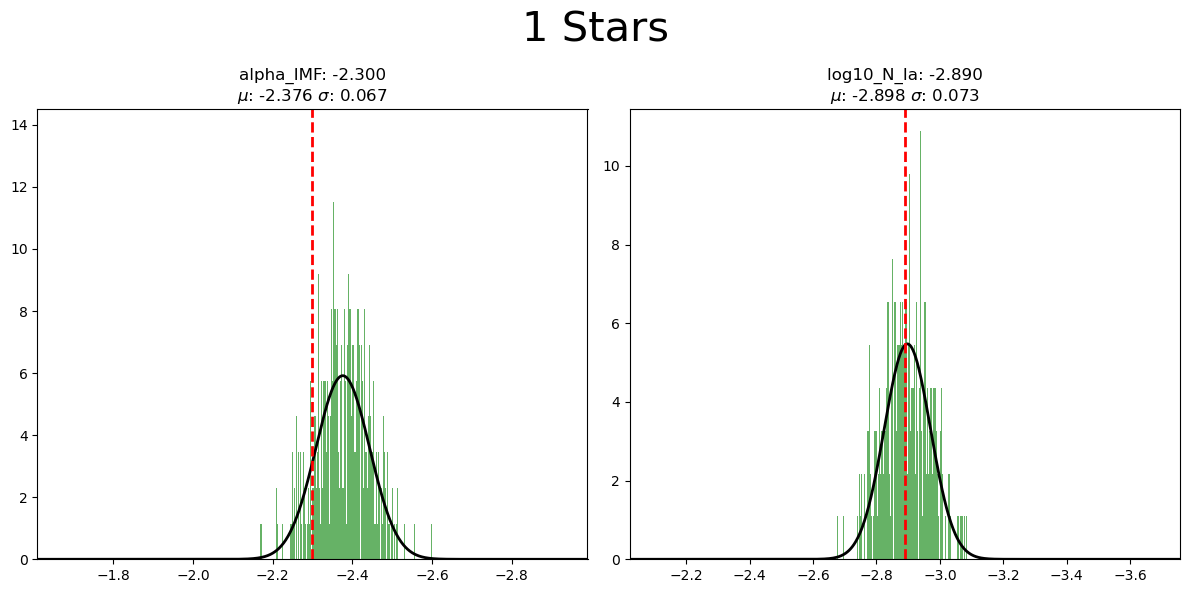

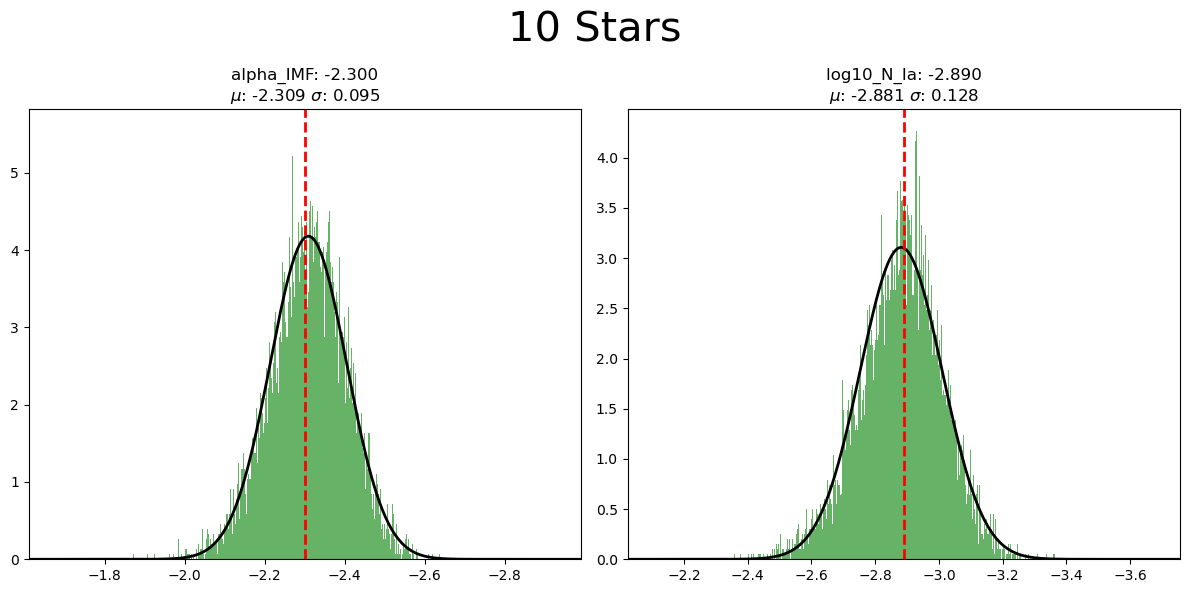

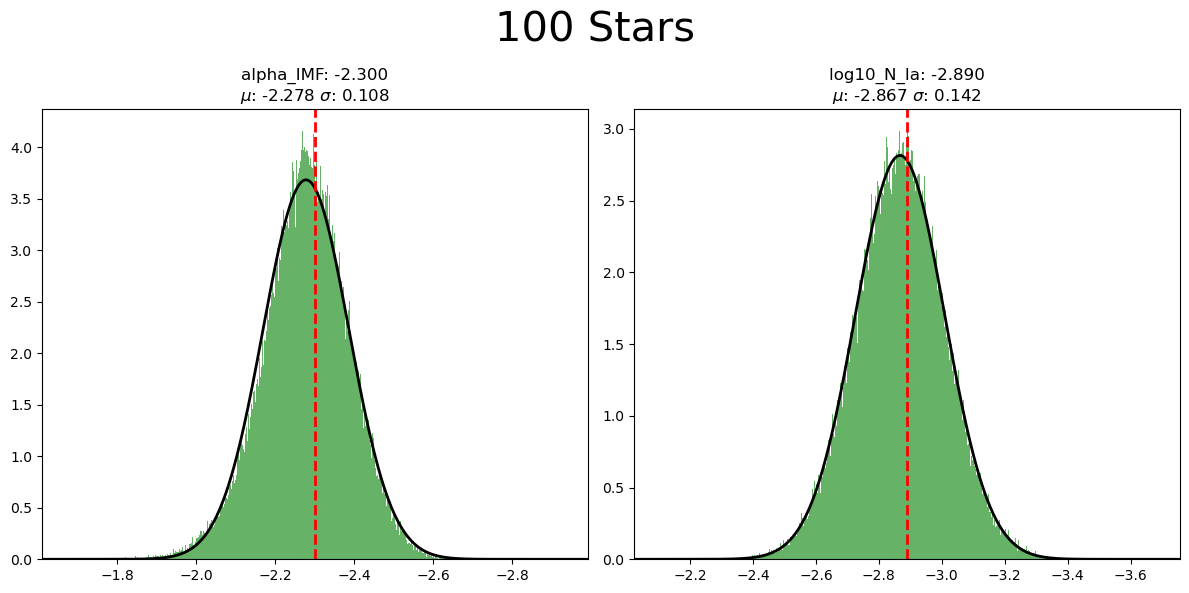

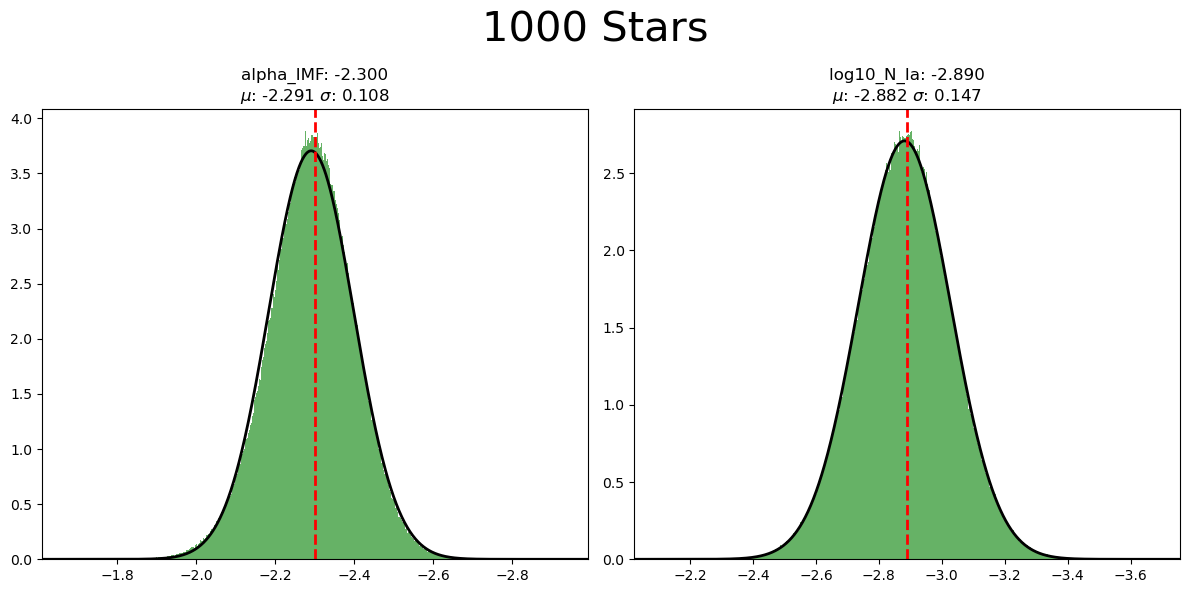

In [ ]:
sims = np.array([1, 10, 100, 1000]) * simulations
print(f"{simulations} simulations for each star")
for i in sims:
    plot_2d_hist(alpha_IMF_obs[0:i], log10_N_Ia_obs[0:i], global_params[0], ['alpha_IMF', 'log10_N_Ia'])

In [400]:
def plot_2d_hist(x1, x2, x_true):
    x_lim, y_lim = [-2.8,-1.8],[-3.4,-2.4]

    # --- Fit a 2D Gaussian to the data ---
    popt, pcov = multivariate_normal.fit(np.array([x1, x2]).T)
    x = np.linspace(x_lim[0], x_lim[1], 1000)
    y = np.linspace(y_lim[0], y_lim[1], 1000)

    X, Y = np.meshgrid(x, y)
    pos = np.empty(X.shape + (2,))

    pos[:, :, 0] = X
    pos[:, :, 1] = Y

    rv = multivariate_normal(popt, pcov)
    perr = np.sqrt(np.diag(pcov))

    # --- Calculate the sigma levels ---
    levels =[]
    sigma = [3,2,1]
    for n in sigma:
        level = rv.pdf(popt+n * np.array([perr[0], perr[1]]))
        levels.append(level)

    # --- Plot the data ---
    plt.figure(figsize=(15,15))
    plt.hist2d(x1, x2, bins=500, range=[x_lim, y_lim])

    # draw contour lines on1,2,3 sigma
    CS = plt.contour(X, Y, rv.pdf(pos), levels=levels, colors='k', linestyles='dashed')
    text = plt.clabel(CS, inline=True, fontsize=10)
    c_labels = np.array(sigma)
    for i in range(len(text)):
        text[i].set(text=f'{c_labels[i]} $\\sigma$')

    plt.scatter(x_true[0], x_true[1], color='r', label='Ground Truth', s=10)
    plt.scatter(popt[0], popt[1], color='k', marker='x', label='Fit')

    plt.title(f'Posterior sampling of {N_stars} stars', fontsize=40)

    plt.xlabel(r'$\alpha_{\rm IMF}$', fontsize=20)
    plt.ylabel(r'$\log_{10} N_{\rm Ia}$', fontsize=20)
    plt.legend()
    plt.show();

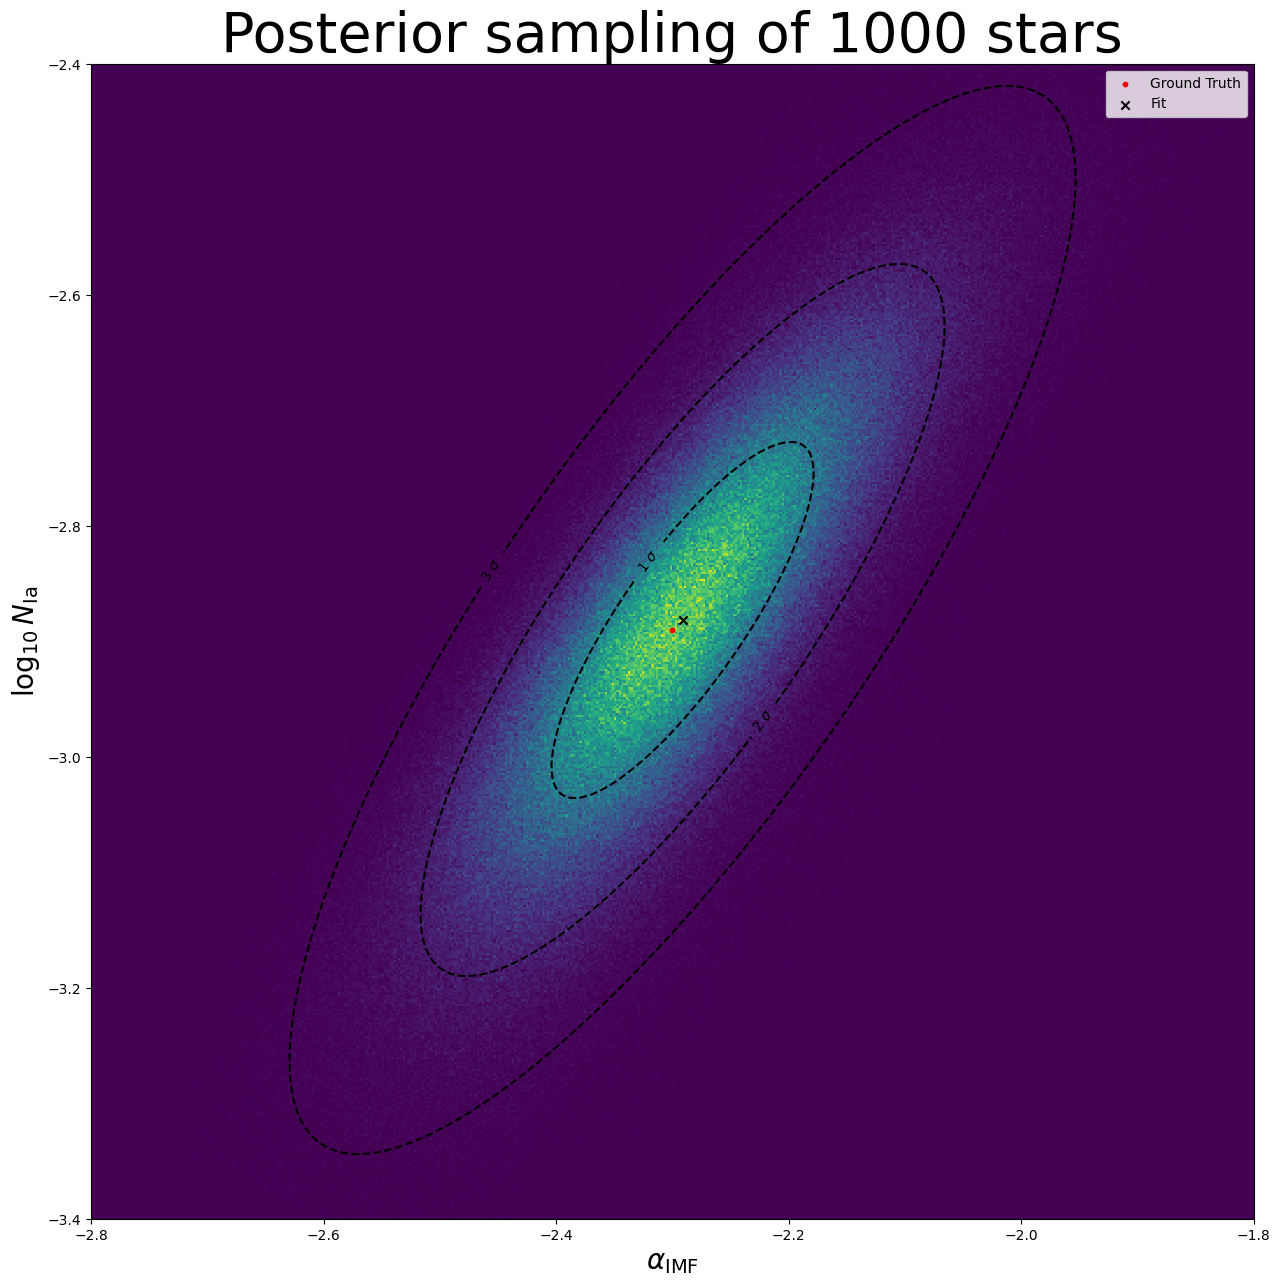

In [401]:
plot_2d_hist(alpha_IMF_obs, log10_N_Ia_obs, global_params[0])

In [398]:
def plot_2d_hist_sides(x1, x2, x_true):
    x_lim, y_lim = [-2.8,-1.8],[-3.4,-2.4]

    # --- Fit a 2D Gaussian to the observed data ---
    popt, pcov = multivariate_normal.fit(np.array([x1, x2]).T)
    x = np.linspace(x_lim[0], x_lim[1], 1000)
    y = np.linspace(y_lim[0], y_lim[1], 1000)

    X, Y = np.meshgrid(x, y)
    pos = np.empty(X.shape + (2,))

    pos[:, :, 0] = X
    pos[:, :, 1] = Y

    rv = multivariate_normal(popt, pcov)
    perr = np.sqrt(np.diag(pcov))

    # --- Calculate the sigma levels ---
    levels =[]
    sigma = [3,2,1]
    for n in sigma:
        level = rv.pdf(popt+n * np.array([perr[0], perr[1]]))
        levels.append(level)

    # --- Plot the data ---
    fig = plt.figure(1, figsize=(15,15))
    
    
    # Define the locations for the axes
    left, width = 0.12, 0.7
    bottom, height = 0.12, 0.7
    bottom_h = left_h = left+width+0.02
    
    # Set up the geometry of the three plots
    rect_temperature = [left, bottom, width, height] # dimensions of temp plot
    rect_histx = [left, bottom_h, width, 0.15] # dimensions of x-histogram
    rect_histy = [left_h, bottom, 0.15, height] # dimensions of y-histogram

    # Make the three plots
    axTemperature = plt.axes(rect_temperature) # temperature plot
    axHistx = plt.axes(rect_histx) # x histogram
    axHisty = plt.axes(rect_histy) # y histogram
    
    # Remove the inner axes numbers of the histograms
    nullfmt = NullFormatter()
    axHistx.xaxis.set_major_formatter(nullfmt)
    axHisty.yaxis.set_major_formatter(nullfmt)

    axHistx.axis('off')
    axHisty.axis('off')


    # Plot the data
    axTemperature.hist2d(x1, x2, bins=500, range=[x_lim, y_lim])

    # draw contour lines on sigma levels
    CS = axTemperature.contour(X, Y, rv.pdf(pos), levels=levels, colors='k', linestyles='dashed')
    text = axTemperature.clabel(CS, inline=True, fontsize=10)
    c_labels = np.array(sigma)
    for i in range(len(c_labels)):
        text[i].set(text=f'{c_labels[i]} $\\sigma$')

    # labels
    label_gt = r'Ground Truth' + f"\n" + r"$\alpha_{\rm IMF} = $" + f'${round(x_true[0].item(), 2)}$' + f"\n" + r"$\log_{10} N_{\rm Ia} = $" + f'${round(x_true[1].item(), 2)}$'
    
    label_fit = r'Fit' + f"\n" + r"$\alpha_{\rm IMF} = $" + f'${round(popt[0].item(), 2)} \\pm {round(perr[0].item(),2)}$' + f"\n" + r"$\log_{10} N_{\rm Ia} = $" + f'${round(popt[1].item(), 2)} \\pm {round(perr[1].item(),2)}$'
    
    # plot the ground truth and the fit
    legend_true = axTemperature.scatter(x_true[0], x_true[1], color='r', label=label_gt, s=10)
    legend_fit = axTemperature.scatter(popt[0], popt[1], color='k', marker='x', label=label_fit)

    axTemperature.set_xlabel(r'$\alpha_{\rm IMF}$', fontsize=20)
    axTemperature.set_ylabel(r'$\log_{10} N_{\rm Ia}$', fontsize=20)
    

    # plot the histograms
    axHistx.hist(x1, bins=500, density=True, alpha=0.6, color='g')
    axHisty.hist(x2, bins=500, density=True, alpha=0.6, color='g', orientation='horizontal')

    axHistx.plot(x, norm.pdf(x, popt[0], perr[0]), 'k', linewidth=2)
    axHisty.plot(norm.pdf(y, popt[1], perr[1]), y, 'k', linewidth=2)

    axHistx.axvline(x=x_true[0], color='r', linestyle='dashed', linewidth=2)
    axHisty.axhline(y=x_true[1], color='r', linestyle='dashed', linewidth=2)

    axHistx.set_xlim(x_lim)
    axHisty.set_ylim(y_lim)

    #fig.text(0.85, 0.95, r'$\alpha_{\rm IMF} = $'+f'${x_true[0]}$', fontsize=20)
    #fig.text(0.85, 0.9, r'$\log_{10} N_{\rm Ia}$', fontsize=20)
    

    fig.legend(handles=[legend_true], fontsize=15, shadow=True, fancybox=True, loc=1, bbox_to_anchor=(0.99, 0.92))
    fig.legend(handles=[legend_fit], fontsize=15, shadow=True, fancybox=True, loc=1, bbox_to_anchor=(0.99, 0.99))
    plt.show()

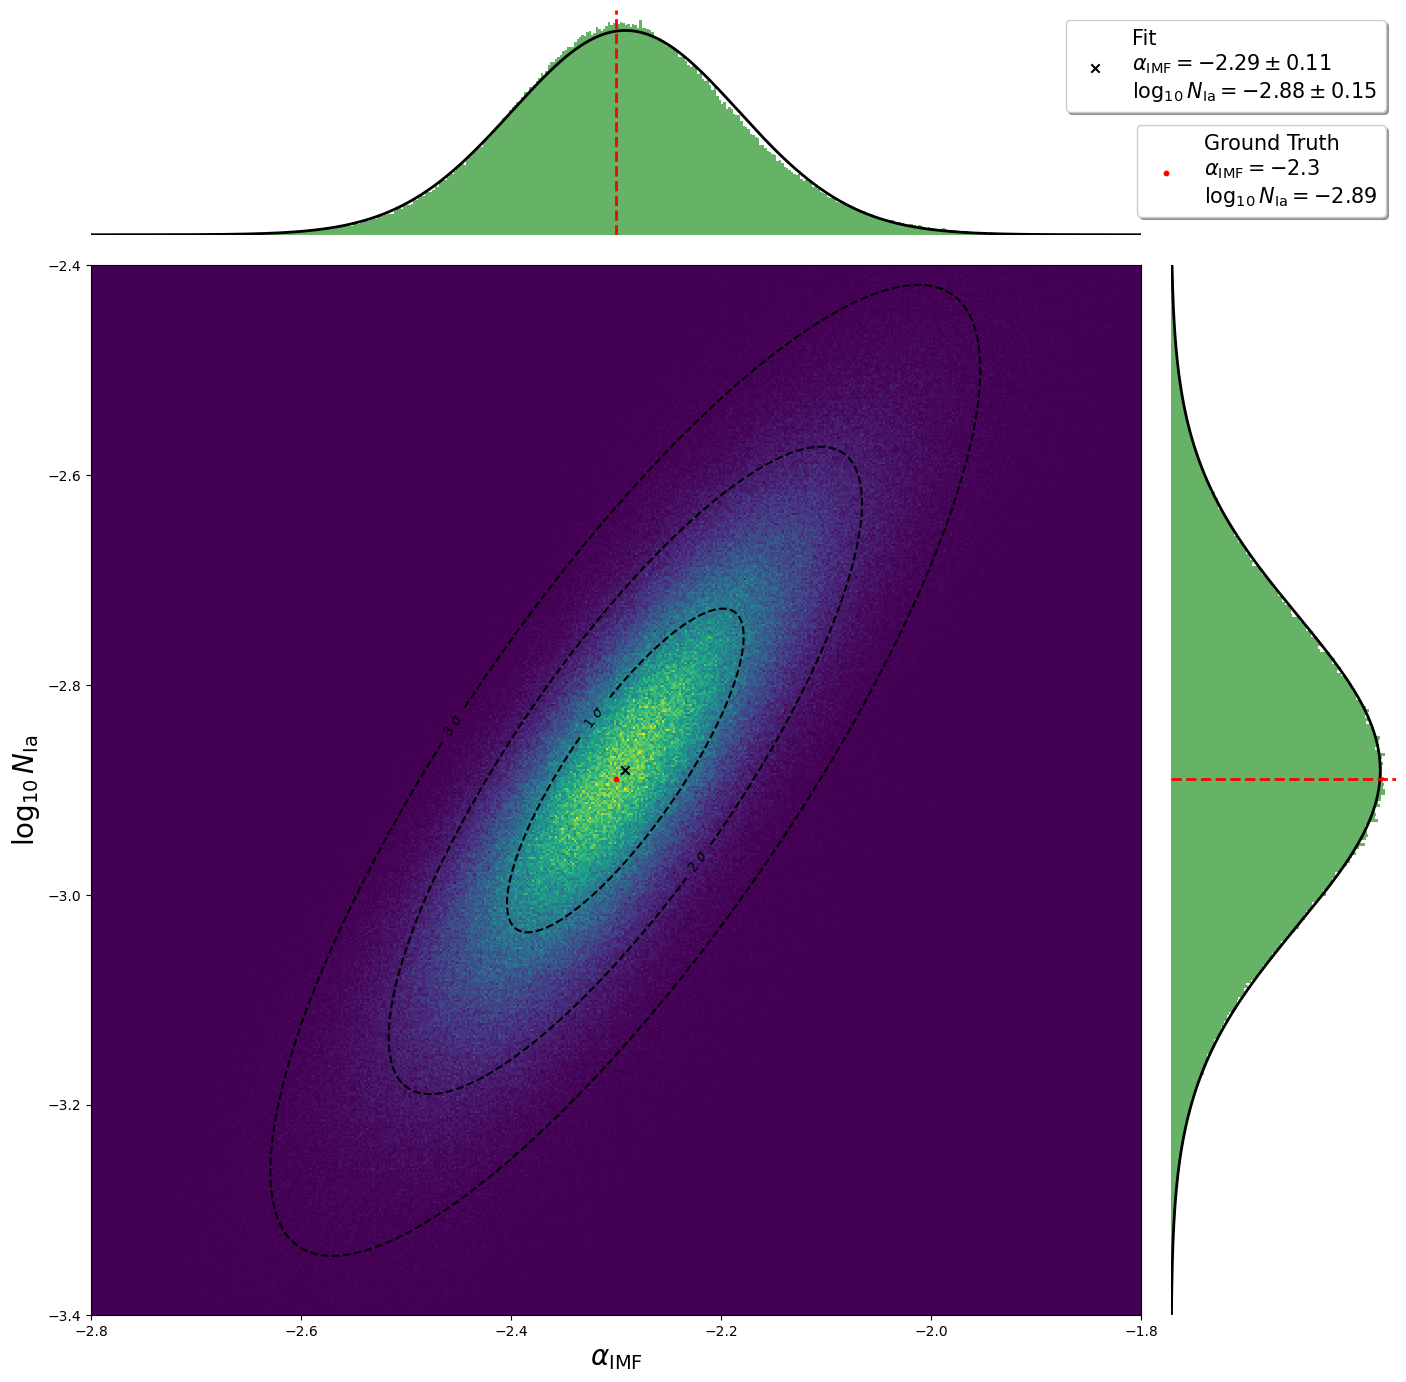

In [399]:
plot_2d_hist_sides(alpha_IMF_obs, log10_N_Ia_obs, global_params[0])